In [1]:
import os
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle as pickle

In [2]:
import prince.config
from prince import core, util, photonfields, cross_sections
from prince import util as pru

CUPY not found for GPU support. Degrading to MKL.


# Setup and save prince_run objects

Before you create the kernel, you can change options in the config.  
See `prince/config.py` for a full list of options

In [3]:
prince.config.x_cut = 1e-4
prince.config.x_cut_proton = 1e-2
prince.config.tau_dec_threshold = np.inf

### Now create the objects:
- Photonfield class
- Cross section class
- PriNCe core class, that will contain the cross section kernel

(The latter two take some time)

Note that TabulatedCrossSection will look for data in the database stored in `./prince/data/prince_db_05`

#### Photon field class

This is a combined photon field of CMB and Gilmore et al. EBL  
See classes in `prince/photonfields.py` for different options

In [4]:
%%time
pf = photonfields.CombinedPhotonField(
                [photonfields.CMBPhotonSpectrum, 
                 photonfields.CIBGilmore2D])

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 16 ms


#### Cross section class

This is a combined cross section of `Talys` as low energy the `Sophia` superposition model at high energies
See classes in `prince/cross_sections.py` for different options

In [5]:
%%time
cs = cross_sections.CompositeCrossSection([(0., cross_sections.TabulatedCrossSection, ('CRP2_TALYS',)),
                                           (0.14, cross_sections.SophiaSuperposition, ())])


CompositeCrossSection::_join_models(): Attempt to join 2 models.
CPU times: user 1min 21s, sys: 5.83 s, total: 1min 27s
Wall time: 49.5 s


#### Prince_run kernel

In [6]:
%%time
prince_run_talys = core.PriNCeRun(max_mass = 56, photon_field=pf, cross_sections=cs)

PriNCeRun::__init__(): initialising Energy grid
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (1105, 1105)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (1005, 1005)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (1004, 1004)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (904, 904)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (704, 704)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (703, 703)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (603, 603)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (402, 402)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (302, 302)
PhotoNuclearInteractionRate::_init_matrices(): Inclusive interpolator not found for (301, 3

### Save the kernel for reuse

Now pickle the core class to some folder (it is a few GB large)  
**Adjust the path to some folder

In [7]:
%%time
target_path = os.path.expanduser("./prince_kernels/")
with open(target_path + 'prince_run_talys_test.ppo','wb') as thefile:
    pickle.dump(prince_run_talys, thefile, protocol = -1)

CPU times: user 1.84 s, sys: 19.1 s, total: 20.9 s
Wall time: 27 s


# Reload the model and test

In [8]:
%%time
target_path = os.path.expanduser("./prince_kernels/")
with open(target_path + 'prince_run_talys_test.ppo','rb') as thefile:
    prince_run_talys = pickle.load(thefile)

CPU times: user 797 ms, sys: 8.59 s, total: 9.39 s
Wall time: 11 s


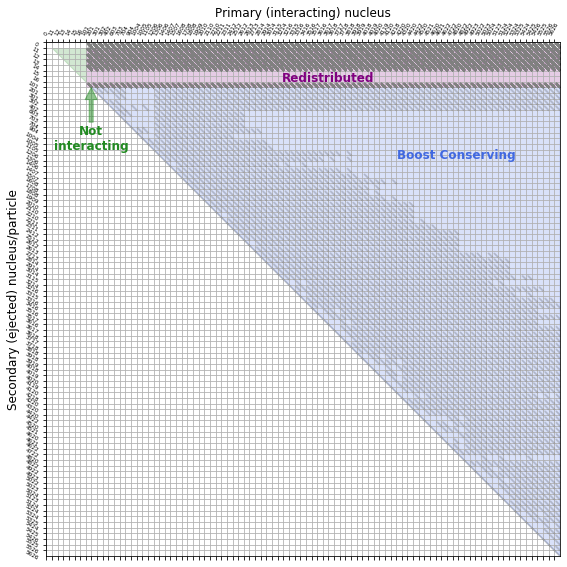

In [9]:
prince_run = prince_run_talys

precision = 0.# 1e-28
jac = prince_run.int_rates.get_hadr_jacobian(1.)

fig, ax = plt.subplots(1,1, figsize=(8,8))
 
photon = prince_run.spec_man.ncoid2sref[11]
proton = prince_run.spec_man.ncoid2sref[101]
iron = prince_run.spec_man.ncoid2sref[5626]

rect = plt.Polygon([(proton.uidx(), proton.uidx()),
                    (iron.uidx(), iron.uidx()),
                    (iron.uidx(), proton.uidx())
                   ],
                    color = 'royalblue', alpha = 0.2)
plt.annotate('Boost Conserving', (6400,1750), 
             color = 'royalblue', ha = 'center', va = 'center', fontsize = 'large', fontweight = 'bold')

ax.add_patch(rect)
rect = plt.Polygon([(proton.lidx(), photon.lidx()),
                    (proton.lidx(), proton.uidx()),
                    (iron.uidx(), proton.uidx()),
                    (iron.uidx(), photon.lidx()),
                    ],
                    color = 'purple', alpha = 0.2)
ax.add_patch(rect)
plt.annotate('Redistributed', (4400,550), 
             color = 'purple', ha = 'center', va = 'center', fontsize = 'large', fontweight = 'bold')

rect = plt.Polygon([(photon.lidx(), photon.lidx()),
#                     (photon.lidx(), proton.lidx()),
                    (proton.lidx(), photon.lidx()),
                    (proton.lidx(), proton.lidx()),
                    ],
                    color = 'forestgreen', alpha = 0.2)
ax.add_patch(rect)
plt.annotate('Not\ninteracting', (700,700), xytext = (700,1500), arrowprops=dict(facecolor='forestgreen', edgecolor = 'forestgreen', shrink=0.01, alpha = 0.5),
             color = 'forestgreen', ha = 'center', va = 'center', fontsize = 'large', fontweight = 'bold')

plt.spy(jac, markersize=0.01, precision = precision, c ='gray')
# plt.imshow(np.log(np.abs(jac.todense())),origin="upper", interpolation='nearest',cmap='binary')

ticks, labels = zip(*[(s.lidx() , s.ncoid) for s in prince_run.spec_man.species_refs][::])

ax.set_xticks(ticks)
ax.set_xticklabels(labels,rotation =60.,fontsize='xx-small')
ax.set_yticks(ticks)
ax.set_yticklabels(labels,rotation =-30, fontsize='xx-small')

ax.set_xlabel(r'Primary (interacting) nucleus',fontsize='large')

ax.xaxis.set_label_position('top') 
ax.set_ylabel(r'Secondary (ejected) nucleus/particle',fontsize='large')
ax.grid()

plt.tight_layout()